In [1]:
# Load packages
library(mgcv)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(grid)
library(writexl)
library(magrittr)
library(rstatix)

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Warning message:
"package 'ggplot2' was built under R version 4.2.0"
Warning message:
"package 'tidyverse' was built under R version 4.2.0"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

Warning message:
"package 'stringr' was built under R version 4.2.0"
Warning message:
"package 'forcats' was built under R version 4.2.0"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::collapse() masks nlme::collapse()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


W

In [2]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
getwd()
rsv.data <- read_csv(file = "Data/infection_status.csv")

[1] "C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project"

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rsv_by_age <- rsv.data %>% arrange(age_days)
rsv_by_age %>% head()

age_days,birthday,consultdate,infection,IgG_PreF,IgA_PreF,IgG_PostF,IgA_PostF,IgG_Ga,IgA_Ga,⋯,IgA_Nn_household,household04,household59,visitnursery_child,visitnursery_house,pregnancytime,contacttotal,contact04,contact59,sex
<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,2006-08-06,2006-09-11,0,443.7900,0.02,361.2800,0.02,4.468288,0.02,⋯,NA,1,0,0,0,NA,NA,NA,NA,1
37,2006-09-04,2006-10-11,0,206.2100,0.05,195.6700,0.05,7.200000,0.05,⋯,NA,NA,0,0,1,NA,NA,NA,NA,1
37,2016-07-30,2016-09-05,0,135.0600,0.02,189.5000,0.49,13.020000,0.02,⋯,NA,3,0,0,0,39,4,1,1,1
39,2016-05-12,2016-06-20,0,249.8800,0.04,547.9500,0.02,12.690000,0.02,⋯,NA,1,0,0,0,42,4,0,0,1
40,2007-05-04,2007-06-13,0,289.8273,0.05,148.1496,0.05,12.124567,0.02,⋯,NA,3,1,0,1,NA,NA,NA,NA,1
42,2016-08-01,2016-09-12,0,221.3700,0.02,84.5700,0.02,5.970000,0.02,⋯,NA,1,0,NA,NA,35,0,NA,NA,1


# Look at the distribution of cases in the dataset #

In [4]:
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
head(tab)

    
     0 1
  36 1 0
  37 2 0
  39 1 0
  40 1 0
  42 1 0
  45 1 0

In [5]:
dframe <- data.frame(age=rownames(tab), infected=tab[,2])
tail(dframe)

,age,infected
,<chr>,<int>
1808,1808,1
1821,1821,1
1823,1823,1
1841,1841,2
1843,1843,1
1854,1854,1


In [6]:
dframe$age <- as.numeric(dframe$age)
tail(dframe)

,age,infected
,<dbl>,<int>
1808,1808,1
1821,1821,1
1823,1823,1
1841,1841,2
1843,1843,1
1854,1854,1


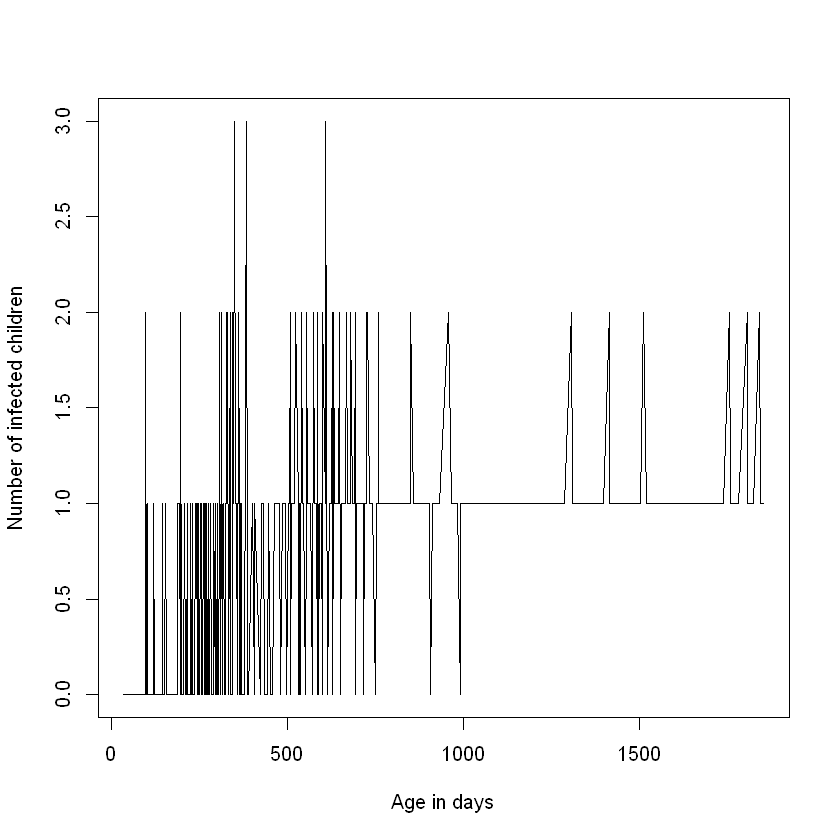

In [7]:
plot(dframe$age, dframe$infected,
     type = "l", xlab = "Age in days", ylab = "Number of infected children")

In [8]:
dframe$cuminfection <- cumsum(dframe$infected)
tail(dframe)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


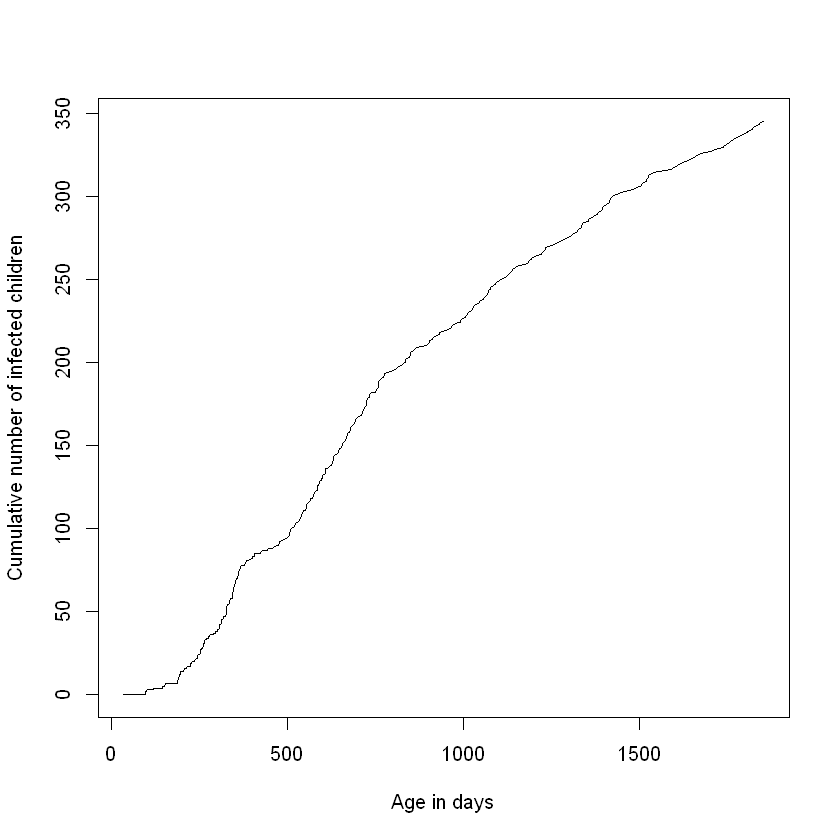

In [9]:
plot(dframe$age, dframe$cuminfection,
     type = "l", xlab = "Age in days", ylab = "Cumulative number of infected children")

In [10]:
dt <- 0.25
sir_data <- mcstate::particle_filter_data(data = dframe,
                                          time = "age",
                                          rate = 1 / dt)
rmarkdown::paged_table(sir_data)

ERROR: Error in mcstate::particle_filter_data(data = dframe, time = "age", rate = 1/dt): Expected each time difference to be one unit


**Write a SIR model**

In [11]:
library(deSolve)

Warning message:
"package 'deSolve' was built under R version 4.2.0"


In [12]:
sir_equations <- function(time, variables, parameters) {
  with(as.list(c(variables, parameters)), {
    dS <- -beta * I * S
    dI <-  beta * I * S - gamma * I
    dR <-  gamma * I
    return(list(c(dS, dI, dR)))
  })
}

In [13]:
parameters_values <- c(
  beta  = 0.004, # infectious contact rate (/person/day)
  gamma = 0.5    # recovery rate (/day)
)

In [36]:
nrow(dframe)

[1] 496

In [14]:
initial_values <- c(
  S = nrow(dframe)-1,  # number of susceptibles at time = 0
  I =   1,  # number of infectious at time = 0
  R =   0   # number of recovered (and immune) at time = 0
)

In [15]:
time_values <- seq(head(dframe$age,1), tail(dframe$age,1)) # days
#time_values

In [16]:
sir_values_1 <- ode(
  y = initial_values,
  times = time_values,
  func = sir_equations,
  parms = parameters_values 
)
sir_values_1 <- as.data.frame(sir_values_1)
sir_values_1

time,S,I,R
<dbl>,<dbl>,<dbl>,<dbl>
36,495.00000,1.000000e+00,0.000000
37,490.49413,4.362813e+00,1.143057
38,471.68770,1.828222e+01,6.030084
39,405.38934,6.564694e+01,24.963721
40,262.25837,1.543382e+02,79.403462
41,125.63953,1.989680e+02,171.392504
42,59.03238,1.711589e+02,265.808765
43,32.73088,1.237393e+02,339.529776
44,21.70957,8.343949e+01,390.850939


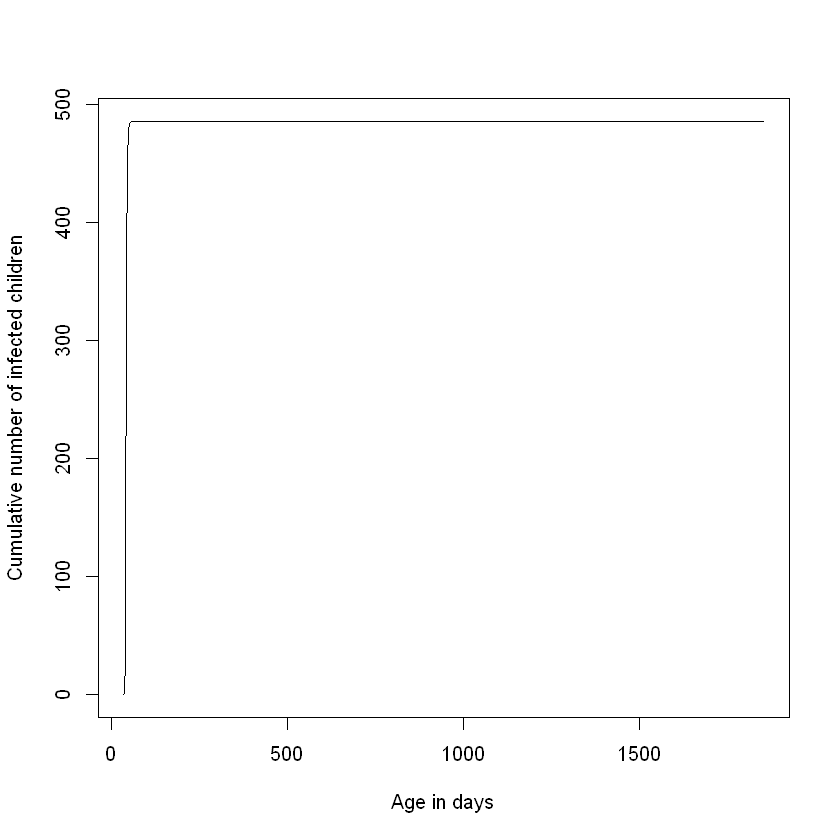

In [17]:
plot(sir_values_1$time, sir_values_1$R,
     type = "l", xlab = "Age in days", ylab = "Cumulative number of infected children")

In [18]:
sir_1 <- function(beta, gamma, S0, I0, R0, times) {
  require(deSolve) # for the "ode" function
# the differential equations:
  sir_equations <- function(time, variables, parameters) {
    with(as.list(c(variables, parameters)), {
      dS <- -beta * I * S
      dI <-  beta * I * S - gamma * I
      dR <-  gamma * I
      return(list(c(dS, dI, dR)))
    })
  }
# the parameters values:
  parameters_values <- c(beta  = beta, gamma = gamma)
# the initial values of variables:
  initial_values <- c(S = S0, I = I0, R = R0)
# solving
  out <- ode(initial_values, times, sir_equations, parameters_values)
# returning the output:
  as.data.frame(out)
}


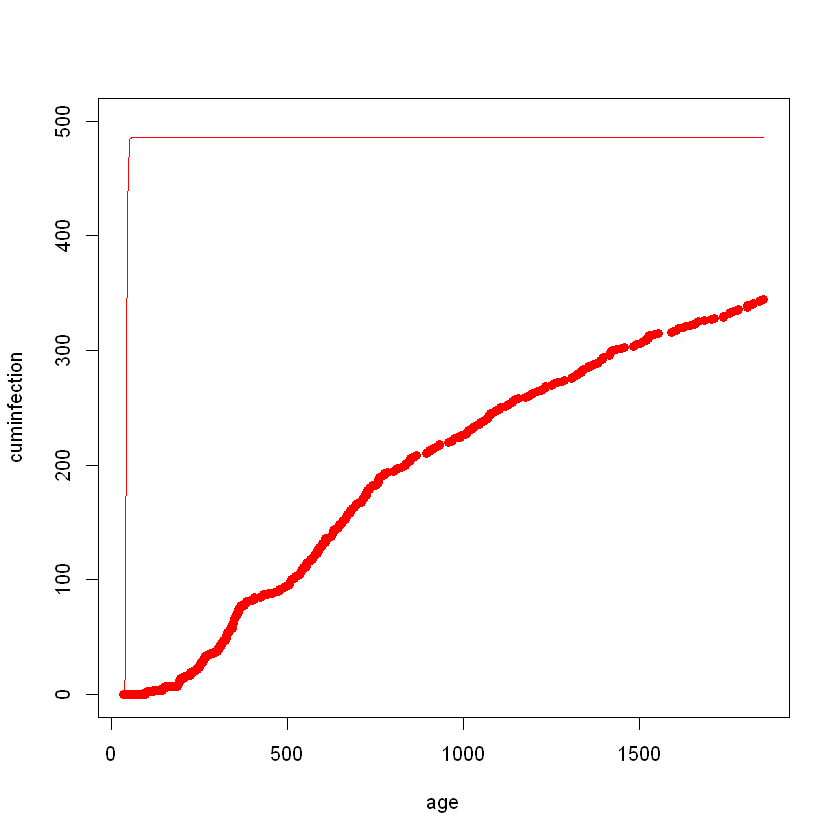

In [23]:
with(dframe, plot(age, cuminfection, pch = 19, col = "red", ylim = c(0, 500)))
predictions <- sir_1(beta = 0.004, gamma = 0.5, S0 = nrow(dframe)-1, I0 = 1, R0 = 0, times = dframe$age)
with(predictions, lines(time, R, col = "red"))

Pretty terrible fit

**Maximum likelihood estimation of beta and gamma**

In [25]:
mLL <- function(beta, gamma, sigma, day, cases, N = nrow(dframe)) {
  beta <- exp(beta) # to make sure that the parameters are positive
  gamma <- exp(gamma)
  sigma <- exp(sigma)
  I0 <- infected[1] # initial number of infectious
  observations <- infected[-1] # the fit is done on the other data points
  predictions <- sir_1(beta = beta, gamma = gamma,
                       S0 = N - I0, I0 = I0, R0 = 0, times = age)
  predictions <- predictions$I[-1] # removing the first point too
# returning minus log-likelihood:
  -sum(dnorm(x = observations, mean = predictions, sd = sigma, log = TRUE))
}

In [28]:
#install.packages("bbmle")
library(bbmle) # for "mle2", "coef", "confint", "vcov", "logLik", "profile", "summary", "plot.profile.mle2"

Loading required package: stats4


Attaching package: 'bbmle'


The following object is masked from 'package:dplyr':

    slice




In [29]:
starting_param_val <- list(beta = 0.004, gamma = 0.5, sigma = 1)
estimates <- mle2(minuslogl = mLL, start = lapply(starting_param_val, log),
                  method = "Nelder-Mead", data = c(dframe, N = nrow(dframe)))

In [30]:
summary(estimates)

Maximum likelihood estimation

Call:
mle2(minuslogl = mLL, start = lapply(starting_param_val, log), 
    method = "Nelder-Mead", data = c(dframe, N = nrow(dframe)))

Coefficients:
       Estimate Std. Error z value   Pr(z)    
beta  -5.320204   0.000000    -Inf < 2e-16 ***
gamma -0.411903   0.000000    -Inf < 2e-16 ***
sigma -0.069151   0.031784 -2.1756 0.02958 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

-2 log L: 1336.217 

In [31]:
exp(coef(estimates))

beta       gamma       sigma 
0.004891757 0.662388798 0.933185509

In [76]:
exp(confint(estimates))

Warning message in proffun(fitted, ...):
"stepsize effectively zero/flat profile (beta)"
Warning message in proffun(fitted, ...):
"stepsize effectively zero/flat profile (beta)"
Warning message in proffun(fitted, ...):
"stepsize effectively zero/flat profile (gamma)"
Warning message in proffun(fitted, ...):
"stepsize effectively zero/flat profile (gamma)"
Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


,2.5 %,97.5 %
beta,NA,NA
gamma,NA,NA
sigma,0.8778812,0.9944073


In [77]:
vcov(estimates)

,beta,gamma,sigma
beta,0,1.456608e-38,-1.067379e-21
gamma,0,0.000000e+00,0.000000e+00
sigma,0,-1.378646e-20,1.010250e-03


In [78]:
-logLik(estimates)

'log Lik.' 668.1083 (df=3)

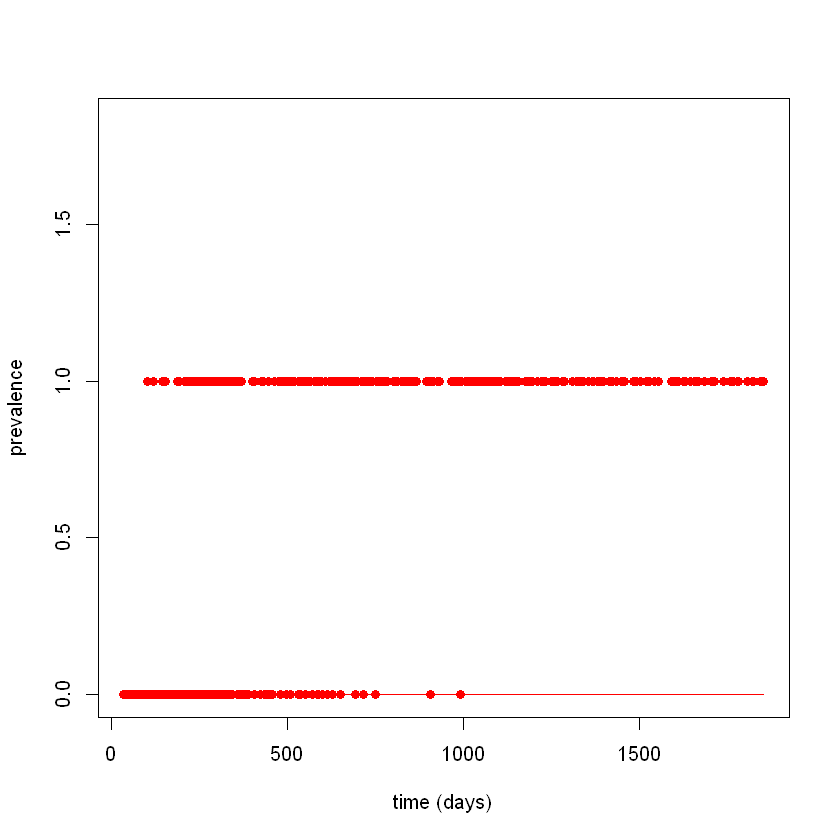

In [32]:
N <- nrow(dframe) # total population size
time_points <- seq(min(dframe$age), max(dframe$age), le = 100) # vector of time points
I0 <- dframe$infected[1] # initial number of infected
param_hat <- exp(coef(estimates)) # parameters estimates
# model's best predictions:
best_predictions <- sir_1(beta = param_hat["beta"], gamma = param_hat["gamma"],
                          S0 = N - I0, I0 = I0, R0 = 0, time_points)$I
# confidence interval of the best predictions:
cl <- 0.95 # confidence level
cl <- (1 - cl) / 2
lwr <- qnorm(p = cl, mean = best_predictions, sd = param_hat["sigma"])
upr <- qnorm(p = 1 - cl, mean = best_predictions, sd = param_hat["sigma"])
# layout of the plot:
plot(time_points, time_points, ylim = c(0, max(upr)), type = "n",
     xlab = "time (days)", ylab = "prevalence")
# adding the predictions' confidence interval:
sel <- time_points >= 1 # predictions start from the second data point
polygon(c(time_points[sel], rev(time_points[sel])), c(upr[sel], rev(lwr[sel])),
        border = NA, col = adjustcolor("red", alpha.f = 0.1))
# adding the model's best predictions:
lines(time_points, best_predictions, col = "red")
# adding the observed data:
with(dframe, points(age, infected, pch = 19, col = "red"))

Not much better

**Try to use mcstate**

In [33]:
#define a dataframe with all days between the youngest age and the oldest age
min = head(dframe$age,1)
max = tail(dframe$age,1)
days <- seq(min, max)
infections <- rep(0, max-min+1)

df <- data.frame(days, infections)

In [111]:
tail(df)

,days,infections
,<int>,<dbl>
1814,1849,0
1815,1850,0
1816,1851,0
1817,1852,0
1818,1853,0
1819,1854,0


In [110]:
tail(dframe)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [34]:
for (d in seq_along(df$days))
    for (a in seq_along(dframe$age))
     if (df$days[d] == dframe$age[a])
         df$infections[d] <- dframe$infected[a]
        

In [35]:
tail(df,15)

,days,infections
,<int>,<dbl>
1805,1840,0
1806,1841,2
1807,1842,0
1808,1843,1
1809,1844,0
1810,1845,0
1811,1846,0
1812,1847,0
1813,1848,0


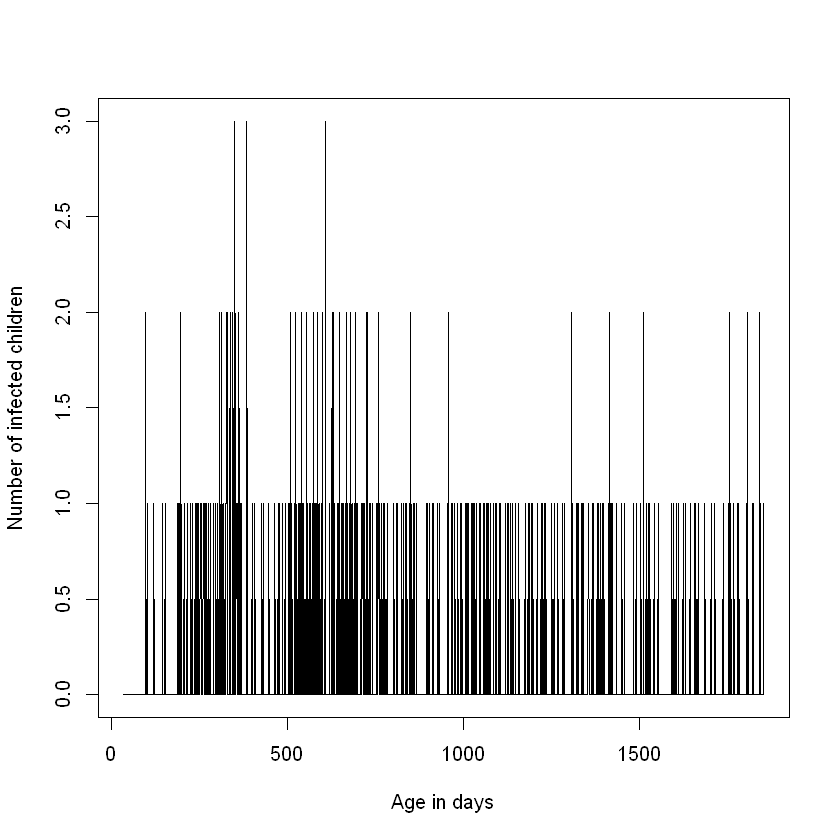

In [36]:
plot(df$days, df$infections,
     type = "l", xlab = "Age in days", ylab = "Number of infected children")

In [37]:
dt <- 0.25
sir_data <- mcstate::particle_filter_data(data = df,
                                          time = "days",
                                          rate = 1 / dt)
rmarkdown::paged_table(sir_data)

days_start,days_end,step_start,step_end,infections
<int>,<int>,<int>,<int>,<dbl>
35,36,140,144,0
36,37,144,148,0
37,38,148,152,0
38,39,152,156,0
39,40,156,160,0
40,41,160,164,0
41,42,164,168,0
42,43,168,172,0
43,44,172,176,0


In [38]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[5, , drop = TRUE]
  incidence_observed <- observed$infections
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [41]:
gen_sir <- dust::dust_example("sir")
gen_sir$new(pars = list(), step = 0, n_particles = 3L)$info()

$vars
[1] "S"           "I"           "R"           "cases_cumul" "cases_inc"  

$pars
$pars$beta
[1] 0.2

$pars$gamma
[1] 0.1

In [42]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$infections, lambda = lambda, log = TRUE)
}

In [43]:
n_particles <- 100
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_sir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 3L)

In [44]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -4780.044

ERROR: Error in matplot(x = x, y = y, type = type, lty = lty, lwd = lwd, pch = pch, : 'x' and 'y' must have same number of rows


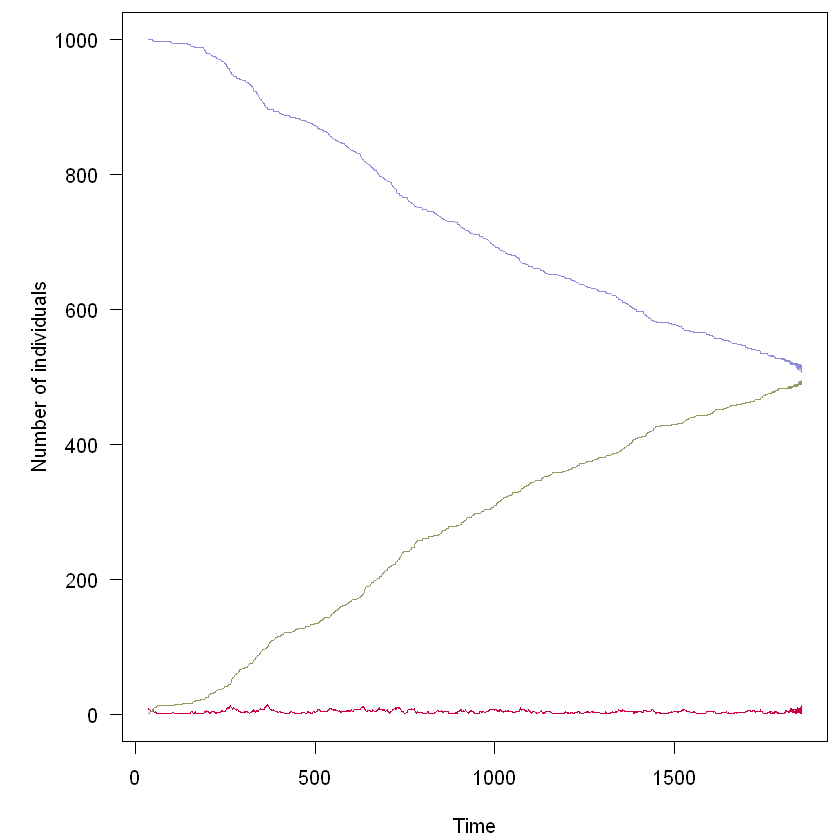

In [49]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, t(history[1, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["S"]], lty = 1, ylim = range(history))
  matlines(times, t(history[2, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, t(history[3, , -1]), col = cols[["R"]], lty = 1)
  matpoints(times[1:obs_end], t(true_history[1:3, , -1]), pch = 19,
            col = cols)
  legend("left", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

#true_history <- df
plot_particle_filter(filter$history(), true_history, df$days)

In [46]:
beta <- mcstate::pmcmc_parameter("beta", 0.2, min = 0)
gamma <- mcstate::pmcmc_parameter("gamma", 0.1, min = 0, prior = function(p)
  dgamma(p, shape = 1, scale = 0.2, log = TRUE))

proposal_matrix <- diag(0.1, 2)
mcmc_pars <- mcstate::pmcmc_parameters$new(list(beta = beta, gamma = gamma),
                                           proposal_matrix)

In [47]:
n_steps <- 500
n_burnin <- 200
control <- mcstate::pmcmc_control(
    n_steps,
    save_state = TRUE,
    save_trajectories = TRUE,
    progress = TRUE)
pmcmc_run <- mcstate::pmcmc(mcmc_pars, filter, control = control)

Running chain 1 / 1


Step 1 / 500 [-------------------------------------] ETA  8m | 00:00:00 so far

Step 2 / 500 [-------------------------------------] ETA  8m | 00:00:01 so far

Step 3 / 500 [-------------------------------------] ETA  7m | 00:00:02 so far

Step 4 / 500 [-------------------------------------] ETA  6m | 00:00:03 so far

Step 5 / 500 [-------------------------------------] ETA  6m | 00:00:03 so far

Step 6 / 500 [-------------------------------------] ETA  6m | 00:00:04 so far

Step 7 / 500 [>------------------------------------] ETA  6m | 00:00:05 so far

Step 8 / 500 [>------------------------------------] ETA  6m | 00:00:05 so far

Step 9 / 500 [>------------------------------------] ETA  6m | 00:00:06 so far

Step 10 / 500 [>-----------------------------------] ETA  6m | 00:00:07 so far

Step 11 / 500 [>-----------------------------------] ETA  6m | 00:00:07 so far

Step 12 / 500 [>-----------------------------------] ETA  6m | 00:00:08 so far

Step 13 / 500 [>--

In [48]:
processed_chains <- mcstate::pmcmc_thin(pmcmc_run, burnin = n_burnin, thin = 2)
parameter_mean_hpd <- apply(processed_chains$pars, 2, mean)
parameter_mean_hpd

beta      gamma 
0.04630430 0.03029146

ERROR: Error in true_history[1:3, , -1]: incorrect number of dimensions


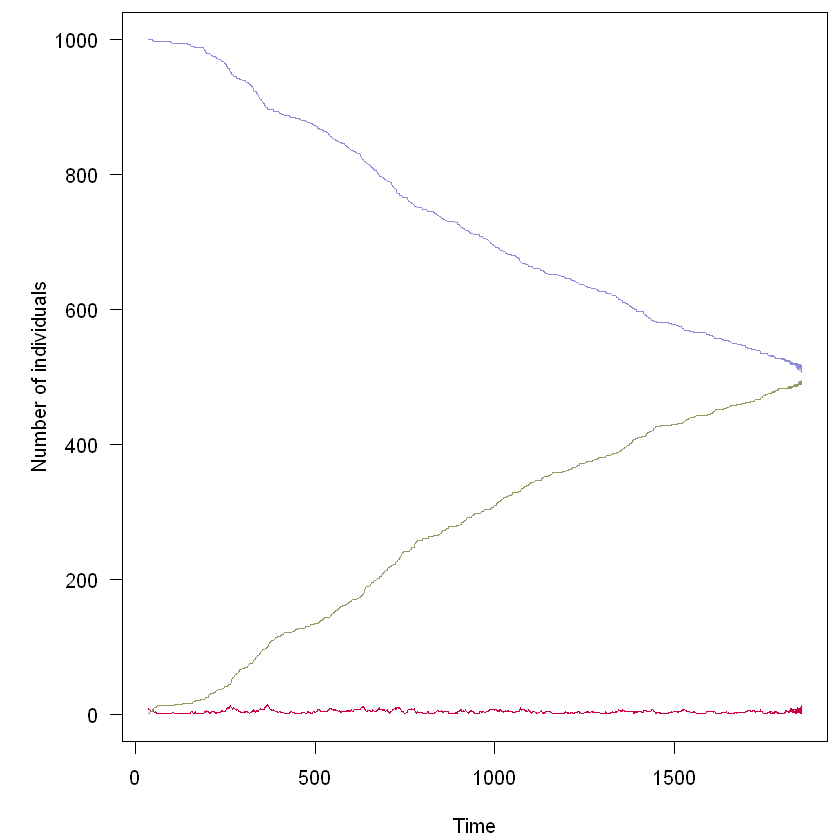

In [53]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, t(history[1, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["S"]], lty = 1, ylim = range(history))
  matlines(times, t(history[2, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, t(history[3, , -1]), col = cols[["R"]], lty = 1)
  matpoints(times[1:obs_end], t(true_history[1:3, , -1]), pch = 19,
            col = cols)
  legend("left", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- df$infection
plot_particle_filter(filter$history(), true_history, time = df$days)

In [55]:
filter$state()

510,510,510,510,510,512,512,512,512,506,⋯,515,515,511,511,511,511,512,512,512,512
8,8,8,8,8,9,9,9,9,13,⋯,4,4,8,8,8,8,6,6,6,6
492,492,492,492,492,489,489,489,489,491,⋯,491,491,491,491,491,491,492,492,492,492
490,490,490,490,490,488,488,488,488,494,⋯,485,485,489,489,489,489,488,488,488,488
1,1,1,1,1,1,1,1,1,2,⋯,1,1,1,1,1,1,1,1,1,1


In [64]:
filter$state(c(S = 1L, R = 3L))

S,510,510,510,510,510,512,512,512,512,506,⋯,515,515,511,511,511,511,512,512,512,512
R,492,492,492,492,492,489,489,489,489,491,⋯,491,491,491,491,491,491,492,492,492,492


In [65]:
tail(dframe$cuminfection,1)

[1] 345

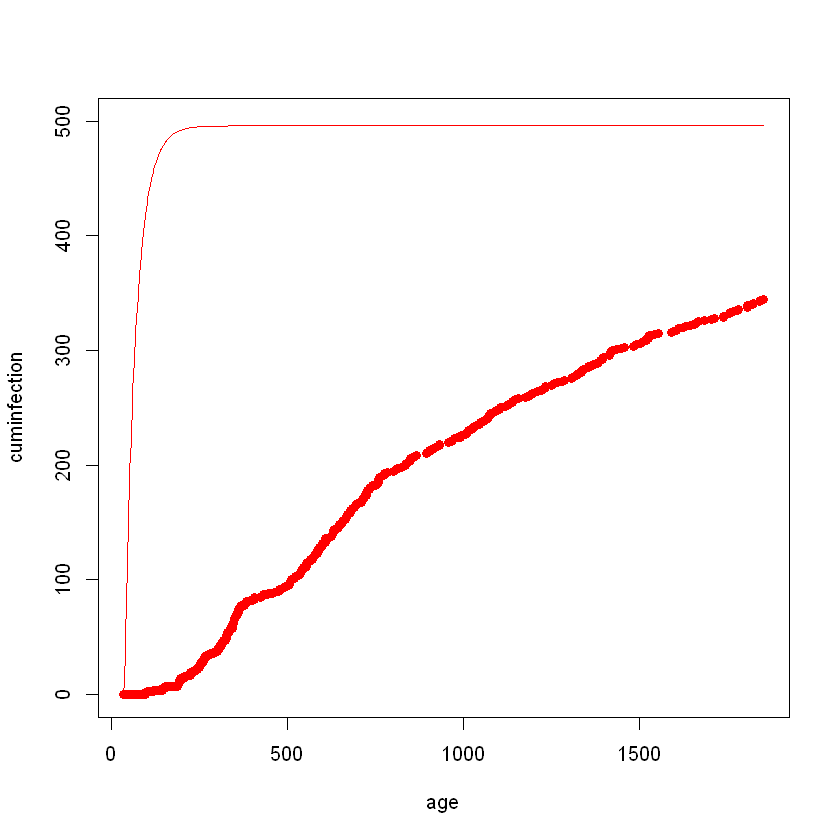

In [66]:
with(dframe, plot(age, cuminfection, pch = 19, col = "red", ylim = c(0, 500)))
predictions <- sir_1(beta = 0.046304300313886, gamma = 0.0302914570193872, S0 = nrow(dframe)-1, I0 = 1, R0 = 0, times = dframe$age)
with(predictions, lines(time, R, col = "red"))